<a target="_blank" href="https://colab.research.google.com/github/makagan/SSI_Projects/blob/main/if_projects/IF-Image-Classifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Particle image classifier

This notebook is an introduction to one of workshop challenges, a particle image classification. Four type of particles (electron, photon, muon, and proton) are simulated in liquid argon medium and the 2D projections of their 3D energy deposition patterns ("trajectories") are recorded. The challenge is to develop a classifier algorithm that identify which of four types is present in an image.

## Setting up

Pull the scripts for the project and download the data files. You only need to do this once per machine/instance you are using.

In [1]:
# ! download_if_dataset.py --challenge=image --flavor=train
# ! download_if_dataset.py --challenge=image --flavor=test

In [2]:
!pip install git+https://github.com/drinkingkazu/ssi_if

  Cloning https://github.com/drinkingkazu/ssi_if to /tmp/pip-req-build-l1701uu9
  Running command git clone --filter=blob:none --quiet https://github.com/drinkingkazu/ssi_if /tmp/pip-req-build-l1701uu9
  Resolved https://github.com/drinkingkazu/ssi_if to commit af38e2ce0730ec5a3091a849bee9e8e53d58042d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 85.6 MB/s eta 0:00:0000:0100:01
  Created wheel for iftools: filename=iftools-0.1-py3-none-any.whl size=6442 sha256=0cbac390241b19deb4d8e9cf32b4555a4dbe16ea9b7b36eaf688dc784944bd2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6f7cl1v/wheels/d8/64/88/5fdb197036df798ef14bcc865874e16890aaa398704495fc75
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=a1a6f76296e3d3b62a5dbd6993960f5f027b701b29feec209abb7bc25f33c05e
  Stored in direc

and setting some global configurations including seeds (change as u see fit!) for reproducibility.

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Data file contents

* A data file with 400,000 images for training: `train.h5`
  * ... which include 100,000 images per particle type
* A data file with 100,000 images for testing: `test.h5`
  * ... which include 25,000 images per particle type

These files are `HDF5` files and can be opened using `h5py`. 


In [2]:
import h5py as h5
datapath='if-image-train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (400000, 192, 192)
dataset index ... type int32 ... shape (400000,)
dataset mean ... type float64 ... shape (1,)
dataset pdg ... type int32 ... shape (400000,)
dataset std ... type float64 ... shape (1,)


# Data Inspection

In [5]:
label_dict = {}
label_dict[11] = "electron"
label_dict[13] = "muon"
label_dict[22] = "photon" 
label_dict[2212] = "proton"

In [6]:
print('Unique values in the label image',np.unique(f['pdg']))

Unique values in the label image [  11   13   22 2212]


PDG code 13
class: muon


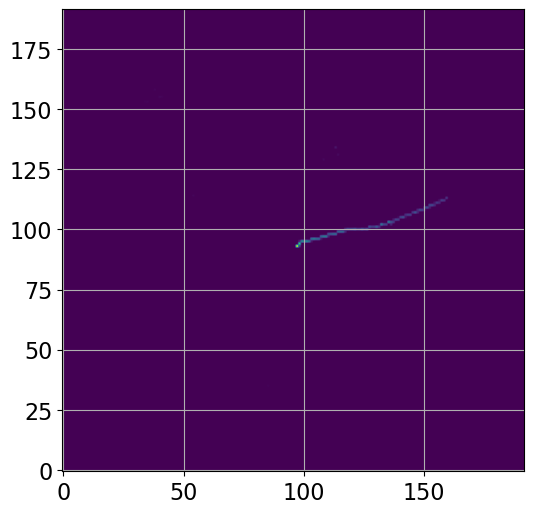

In [7]:
entry = 2

print('PDG code',f['pdg'][entry])
print(f"class: {label_dict[f['pdg'][entry]]}")
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 11
class: electron


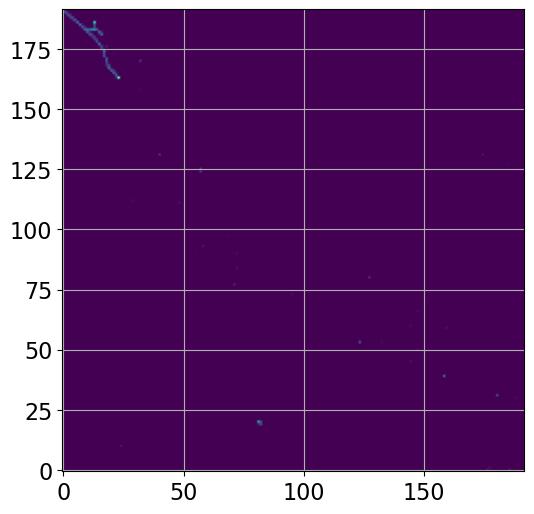

In [8]:
entry = 3

print('PDG code',f['pdg'][entry])
print(f"class: {label_dict[f['pdg'][entry]]}")
plt.imshow(f['image'][entry],origin='lower')
plt.show()

In [9]:
for i in range(100):
    if label_dict[f['pdg'][i]] == "proton":
        print(i)
        break

4


PDG code 22
class: photon


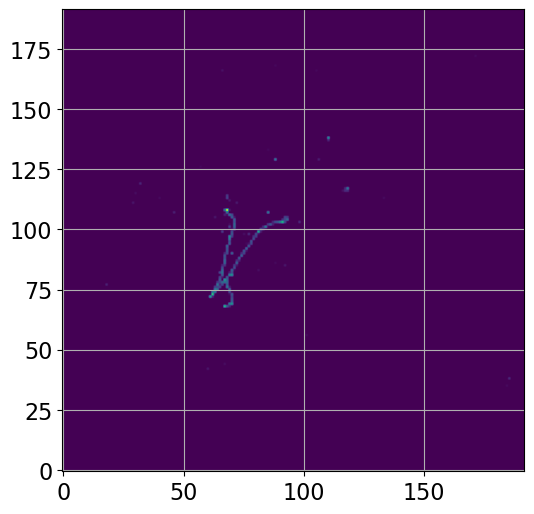

In [10]:
entry = 12

print('PDG code',f['pdg'][entry])
print(f"class: {label_dict[f['pdg'][entry]]}")
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 2212
class: proton


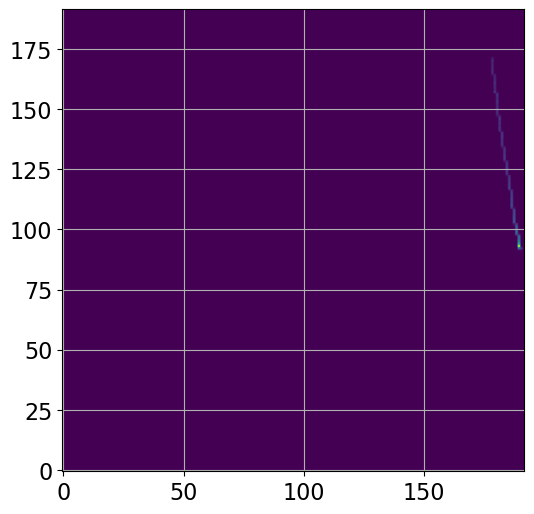

In [11]:
entry = 4

print('PDG code',f['pdg'][entry])
print(f"class: {label_dict[f['pdg'][entry]]}")
plt.imshow(f['image'][entry],origin='lower')
plt.show()

## Class Balance

In [12]:
# class_dict = {}
# class_dict["electron"] = 0
# class_dict["muon"] = 0
# class_dict["photon"] = 0
# class_dict["proton"] = 0

# for i in range(f["pdg"].shape[0]):
# # for i in range(10000):
#     class_dict[label_dict[f["pdg"][i]]] += 1

In [13]:
# class_dict

PDG code 13 means muon (if you are unfamiliar, "PDG code" is a signed integer as a unique identifier of a particle. See [this documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf) for more details.)

Let's don't forget to close the file :)

In [14]:
f.close()

## Particle Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [3]:
from iftool.image_challenge import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Size of dataset 400000
List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 

Again 0-th image! PDG code 22 ... label 2 



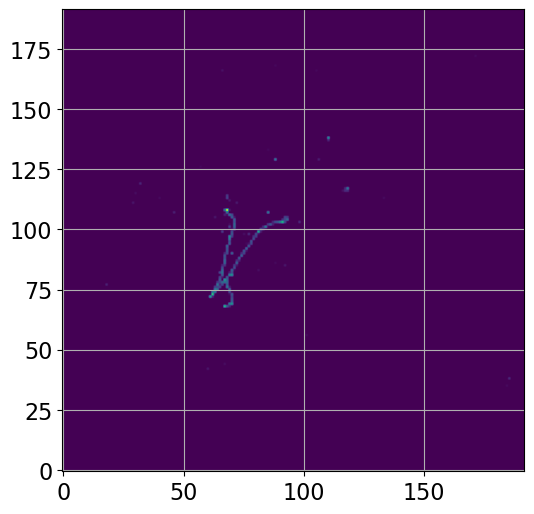

In [16]:
print('Size of dataset',len(train_data))

# Access the 0-th instance
data = train_data[12]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 0-th image! PDG code %d ... label %d \n' % (data['pdg'],data['label']))
plt.imshow(data['data'],origin='lower')
plt.show()

In [17]:
train_data.classes

[11, 13, 22, 2212]

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [4]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.01, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )
val_data = ParticleImage2D(data_files = [datapath],
                             start = 0.1, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.101, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from iftool.image_challenge import collate
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
#                           num_workers = 4,
                          batch_size  = batch_size
                         )
val_loader = DataLoader(val_data,
                          collate_fn  = collate,
                          shuffle     = True,
#                           num_workers = 4,
                          batch_size  = batch_size
                         )

In [5]:
len(train_data)

4000

In [6]:
len(val_data)

400

Let's measure the speed of the dataloader

In [20]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

NameError: name 'model' is not defined

In [ ]:
batch.keys()

In [ ]:
batch["data"][0].shape

## Challenge

Here are open-ended challenge project for an image classification.

* Design a machine learning algorithm for performing image classification task. Report the performance (speed, memory, and classification accuracy) you achieved on the test set (remember, use the test set to only benchmark, don't use it for hyper parameter tuning nor training the model!). You might just train very long time, modify the network architecture, or come up with a better training strategy. Let us know what you tried and found!

If you want more guidance, you could try the steps below. But stay open minded and try what you think interesting!

1. Write a python script that trains your model for 70,000 steps using 90% of training sample. Store the network weights every 2500 steps. 

2. Use 10% of training sample as a validation set. Quantify the performance (loss and accuracy) on the stored weights (at every 2500 steps) by running the network inference on the full validation set. You can do this after training is over, or while you are training the network.

3. Look for features in mistakes made by the network. When is it hard for the network to identify a particle? Can you engineer variables to guide this search (e.g. number of pixel count per image v.s. softmax score, average pixel value, etc.)?

4. Play with the network architecture. For instance, if you designed a CNN, could you implement a residual connection? How does that affect the speed and performance of your network?

5. Can we speed-up the network (training time and/or inference time)? What's the trade-off with its performance on the task (i.e. accuracy)? 

## Strategy
First train a vanilla cnn as baseline  
Then try to use sparse cnn  

Could encode rotational invariance

In [68]:


learning_rate = 0.001
epochs = 10


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(5, 5)
        self.fc1 = nn.Linear(8214, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024,128)
        self.fc4 = nn.Linear(128,4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1, 8214)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.softmax(self.fc3(x), dim = 1)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model = CNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_total_steps = len(train_loader)

train_its = int(len(train_data) / batch_size)
val_its = int(len(val_data) / batch_size)



In [23]:
for i, batch in enumerate(train_loader):
    break
    

In [27]:
images = batch["data"]
labels = batch["label"]
images = images.to(device)
labels = labels.to(device)

In [32]:
images.shape

torch.Size([128, 1, 192, 192])

In [29]:
conv1 = nn.Conv2d(1, 12, kernel_size=5).to(device)

In [31]:
conv1(images).shape

torch.Size([128, 12, 188, 188])

In [33]:
conv2 = nn.Conv2d(12, 6, kernel_size=3).to(device)

In [34]:
conv2(conv1(images)).shape

torch.Size([128, 6, 186, 186])

In [44]:
max_pool = nn.MaxPool2d(5, 5).to(device)

In [45]:
max_pool(conv2(conv1(images))).shape

torch.Size([128, 6, 37, 37])

In [46]:
max_pool(conv2(conv1(images))).view(-1, 8214).shape

torch.Size([128, 8214])

In [47]:
fc1 = nn.Linear(1024, 256).to(device)

In [48]:
fc1(max_pool(conv2(conv1(images))).view(-1, 8214))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x8214 and 1024x256)

In [69]:
train_losses = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    l_train_epoch = []
    l_val_epoch = []
    model.train()
    pbar = tqdm.tqdm(train_loader, total=train_its)
    for i, batch in enumerate(pbar):
        images = batch["data"]
        labels = batch["label"]
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        l_train_epoch.append(loss.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f} ')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar = tqdm.tqdm(val_loader, total=val_its)
        for i, batch in enumerate(pbar):
            images = batch["data"]
            labels = batch["label"]
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            l_val_epoch.append(loss.detach().cpu())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

            if (i+1) % 2 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Val Loss: {loss.item():.4f} ')
    val_acc = correct/total
    print(f"val accuracy: {val_acc}")
    val_accs.append(val_acc)
    l_train = np.mean(l_train_epoch)
    l_val = np.mean(l_val_epoch)
    train_losses.append(l_train)
    val_losses.append(l_val)

 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:08,  2.60it/s]

Epoch [1/10], Step [10/32], Training Loss: 1.3847 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.34it/s]

Epoch [1/10], Step [20/32], Training Loss: 1.2901 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.21it/s]

Epoch [1/10], Step [30/32], Training Loss: 1.1264 


32it [00:12,  2.61it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.80it/s]

Epoch [1/10], Step [2/32], Val Loss: 1.1607 


4it [00:01,  3.08it/s]                                                                                                                 


Epoch [1/10], Step [4/32], Val Loss: 1.2556 
val accuracy: 0.2875


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:09,  2.33it/s]

Epoch [2/10], Step [10/32], Training Loss: 1.0321 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.33it/s]

Epoch [2/10], Step [20/32], Training Loss: 1.0593 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.42it/s]

Epoch [2/10], Step [30/32], Training Loss: 0.8898 


32it [00:12,  2.56it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.80it/s]

Epoch [2/10], Step [2/32], Val Loss: 0.7495 


4it [00:01,  3.07it/s]                                                                                                                 


Epoch [2/10], Step [4/32], Val Loss: 1.0368 
val accuracy: 0.665


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:08,  2.49it/s]

Epoch [3/10], Step [10/32], Training Loss: 0.5361 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.34it/s]

Epoch [3/10], Step [20/32], Training Loss: 0.5615 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.34it/s]

Epoch [3/10], Step [30/32], Training Loss: 0.5379 


32it [00:12,  2.58it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.81it/s]

Epoch [3/10], Step [2/32], Val Loss: 0.6027 


4it [00:01,  3.35it/s]                                                                                                                 


Epoch [3/10], Step [4/32], Val Loss: 0.8112 
val accuracy: 0.7025


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:08,  2.60it/s]

Epoch [4/10], Step [10/32], Training Loss: 0.3550 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.61it/s]

Epoch [4/10], Step [20/32], Training Loss: 0.3738 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.61it/s]

Epoch [4/10], Step [30/32], Training Loss: 0.4042 


32it [00:11,  2.74it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.79it/s]

Epoch [4/10], Step [2/32], Val Loss: 0.6385 


4it [00:01,  3.34it/s]                                                                                                                 


Epoch [4/10], Step [4/32], Val Loss: 0.7689 
val accuracy: 0.7425


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:09,  2.33it/s]

Epoch [5/10], Step [10/32], Training Loss: 0.2952 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.33it/s]

Epoch [5/10], Step [20/32], Training Loss: 0.2485 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.33it/s]

Epoch [5/10], Step [30/32], Training Loss: 0.2153 


32it [00:12,  2.54it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.51it/s]

Epoch [5/10], Step [2/32], Val Loss: 0.6879 


4it [00:01,  2.87it/s]                                                                                                                 


Epoch [5/10], Step [4/32], Val Loss: 0.7125 
val accuracy: 0.775


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:09,  2.33it/s]

Epoch [6/10], Step [10/32], Training Loss: 0.1630 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.35it/s]

Epoch [6/10], Step [20/32], Training Loss: 0.1476 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.36it/s]

Epoch [6/10], Step [30/32], Training Loss: 0.1310 


32it [00:12,  2.56it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.80it/s]

Epoch [6/10], Step [2/32], Val Loss: 0.7118 


4it [00:01,  3.08it/s]                                                                                                                 


Epoch [6/10], Step [4/32], Val Loss: 0.3815 
val accuracy: 0.7575


 32%|███████████████████████████████▌                                                                  | 10/31 [00:04<00:09,  2.24it/s]

Epoch [7/10], Step [10/32], Training Loss: 0.0577 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.34it/s]

Epoch [7/10], Step [20/32], Training Loss: 0.1025 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.33it/s]

Epoch [7/10], Step [30/32], Training Loss: 0.1531 


32it [00:12,  2.54it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.80it/s]

Epoch [7/10], Step [2/32], Val Loss: 1.1340 


4it [00:01,  3.09it/s]                                                                                                                 


Epoch [7/10], Step [4/32], Val Loss: 1.4757 
val accuracy: 0.725


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:09,  2.33it/s]

Epoch [8/10], Step [10/32], Training Loss: 0.0403 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.33it/s]

Epoch [8/10], Step [20/32], Training Loss: 0.0268 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.38it/s]

Epoch [8/10], Step [30/32], Training Loss: 0.0474 


32it [00:12,  2.54it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.52it/s]

Epoch [8/10], Step [2/32], Val Loss: 0.8537 


4it [00:01,  2.66it/s]                                                                                                                 


Epoch [8/10], Step [4/32], Val Loss: 1.7501 
val accuracy: 0.745


 32%|███████████████████████████████▌                                                                  | 10/31 [00:03<00:08,  2.38it/s]

Epoch [9/10], Step [10/32], Training Loss: 0.0185 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.33it/s]

Epoch [9/10], Step [20/32], Training Loss: 0.0309 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.33it/s]

Epoch [9/10], Step [30/32], Training Loss: 0.0039 


32it [00:12,  2.56it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.95it/s]

Epoch [9/10], Step [2/32], Val Loss: 1.3055 


4it [00:01,  3.07it/s]                                                                                                                 


Epoch [9/10], Step [4/32], Val Loss: 1.6575 
val accuracy: 0.7375


 32%|███████████████████████████████▌                                                                  | 10/31 [00:04<00:08,  2.34it/s]

Epoch [10/10], Step [10/32], Training Loss: 0.0111 


 65%|███████████████████████████████████████████████████████████████▏                                  | 20/31 [00:07<00:04,  2.39it/s]

Epoch [10/10], Step [20/32], Training Loss: 0.0197 


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 30/31 [00:11<00:00,  2.33it/s]

Epoch [10/10], Step [30/32], Training Loss: 0.0026 


32it [00:12,  2.54it/s]                                                                                                                
 67%|██████████████████████████████████████████████████████████████████▋                                 | 2/3 [00:00<00:00,  2.80it/s]

Epoch [10/10], Step [2/32], Val Loss: 1.0347 


4it [00:01,  3.08it/s]                                                                                                                 


Epoch [10/10], Step [4/32], Val Loss: 2.4686 
val accuracy: 0.715


/tmp/ipykernel_288/2506002365.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("train loss", "val loss")


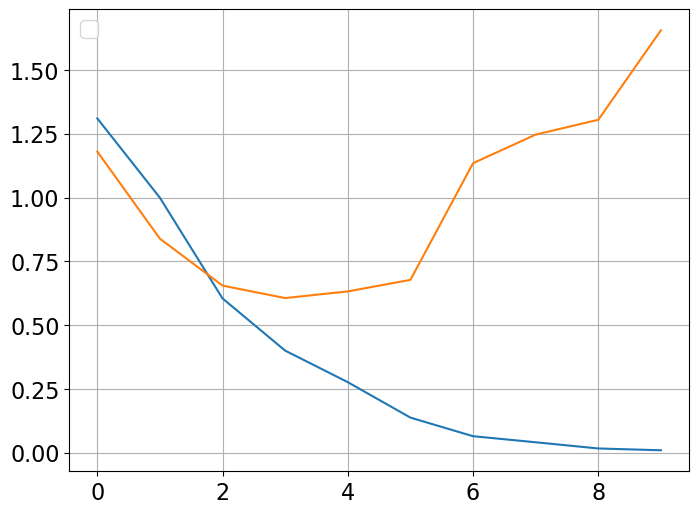

In [70]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend("train loss", "val loss")

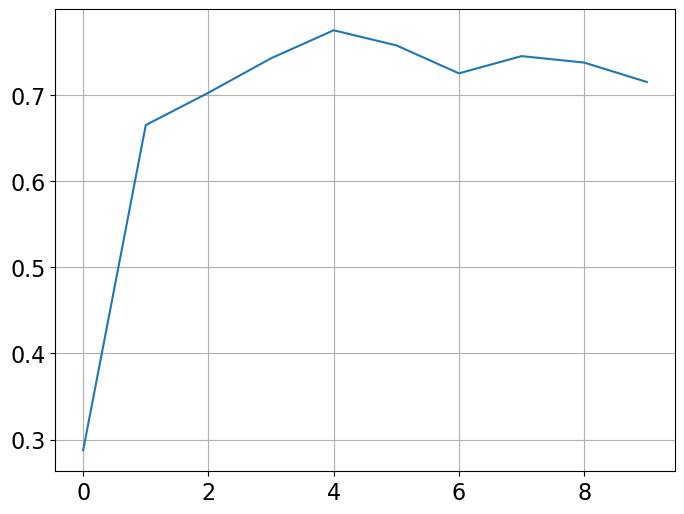

In [71]:
plt.plot(val_accs)

In [72]:
val_accs

[0.2875, 0.665, 0.7025, 0.7425, 0.775, 0.7575, 0.725, 0.745, 0.7375, 0.715]

In [65]:
with torch.no_grad():
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm.tqdm(val_loader, total=val_its)
    for i, batch in enumerate(pbar):
        images = batch["data"]
        labels = batch["label"]
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} validation images: {} %'.format(400, 100 * correct / total)) 

4it [00:01,  3.49it/s]                                                                                                                 

Accuracy of the network on the 5000 validation images: 76.5 %


In [67]:
with torch.no_grad():
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm.tqdm(train_loader, total=val_its)
    for i, batch in enumerate(pbar):
        images = batch["data"]
        labels = batch["label"]
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} training images: {} %'.format(len(train_data), 100 * correct / total)) 

32it [00:12,  2.63it/s]                                                                                                                

Accuracy of the network on the 4000 validation images: 90.575 %


## With dropout

In [20]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.04, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )
val_data = ParticleImage2D(data_files = [datapath],
                             start = 0.1, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.104, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from iftool.image_challenge import collate
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
#                           num_workers = 4,
                          batch_size  = batch_size
                         )
val_loader = DataLoader(val_data,
                          collate_fn  = collate,
                          shuffle     = True,
#                           num_workers = 4,
                          batch_size  = batch_size
                         )

In [21]:
len(train_data)

16000

In [22]:
len(val_data)

1600

In [23]:
learning_rate = 0.001


class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.dropout2d = nn.Dropout2d(p=0.1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(5, 5)
        self.fc1 = nn.Linear(8214, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024,128)
        self.fc4 = nn.Linear(128,4)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = self.dropout2d(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2d(x)
        x = self.max_pool(x)
        x = x.view(-1, 8214)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
model = CNN_dropout().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_total_steps = len(train_loader)

train_its = int(len(train_data) / batch_size)
val_its = int(len(val_data) / batch_size)

In [24]:
train_losses = []
val_losses = []
val_accs = []
val_acc_best = 0
epochs = 15

for epoch in range(epochs):
    l_train_epoch = []
    l_val_epoch = []
    model.train()
    pbar = tqdm.tqdm(train_loader, total=train_its)
    for i, batch in enumerate(pbar):
        images = batch["data"]
        labels = batch["label"]
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        l_train_epoch.append(loss.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if (i+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f} ')
    l_train = np.mean(l_train_epoch)
    train_losses.append(l_train)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {l_train:.4f} ')
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar = tqdm.tqdm(val_loader, total=val_its)
        for i, batch in enumerate(pbar):
            images = batch["data"]
            labels = batch["label"]
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            l_val_epoch.append(loss.detach().cpu())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

#             if (i+1) % 2 == 0:
#                 print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Val Loss: {loss.item():.4f} ')
    val_acc = correct/total
    print(f"val accuracy: {val_acc}")
    val_accs.append(val_acc)
    
    l_val = np.mean(l_val_epoch)
    print(f'Epoch [{epoch+1}/{epochs}], Val Loss: {l_val:.4f} ')
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print("new best model")
        torch.save(model.state_dict(), "CNN_dropout_best.pth")
    
    val_losses.append(l_val)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [1/15], Train Loss: 0.8816 


13it [00:03,  3.43it/s]                                                                                                                


val accuracy: 0.760625
Epoch [1/15], Val Loss: 0.5110 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:40<00:00,  3.09it/s]


Epoch [2/15], Train Loss: 0.6080 


13it [00:04,  3.02it/s]                                                                                                                


val accuracy: 0.739375
Epoch [2/15], Val Loss: 0.5272 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:38<00:00,  3.22it/s]


Epoch [3/15], Train Loss: 0.5471 


13it [00:04,  3.03it/s]                                                                                                                


val accuracy: 0.7725
Epoch [3/15], Val Loss: 0.4209 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:42<00:00,  2.91it/s]


Epoch [4/15], Train Loss: 0.5174 


13it [00:04,  3.10it/s]                                                                                                                


val accuracy: 0.794375
Epoch [4/15], Val Loss: 0.4113 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [5/15], Train Loss: 0.4553 


13it [00:03,  3.43it/s]                                                                                                                


val accuracy: 0.824375
Epoch [5/15], Val Loss: 0.3663 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [6/15], Train Loss: 0.4221 


13it [00:04,  3.03it/s]                                                                                                                


val accuracy: 0.803125
Epoch [6/15], Val Loss: 0.3785 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:39<00:00,  3.14it/s]


Epoch [7/15], Train Loss: 0.3730 


13it [00:04,  2.96it/s]                                                                                                                


val accuracy: 0.814375
Epoch [7/15], Val Loss: 0.3723 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [8/15], Train Loss: 0.3496 


13it [00:03,  3.26it/s]                                                                                                                


val accuracy: 0.80875
Epoch [8/15], Val Loss: 0.3936 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:37<00:00,  3.30it/s]


Epoch [9/15], Train Loss: 0.3142 


13it [00:03,  3.34it/s]                                                                                                                


val accuracy: 0.833125
Epoch [9/15], Val Loss: 0.3552 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:40<00:00,  3.09it/s]


Epoch [10/15], Train Loss: 0.2899 


13it [00:04,  3.10it/s]                                                                                                                


val accuracy: 0.82625
Epoch [10/15], Val Loss: 0.4016 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:38<00:00,  3.21it/s]


Epoch [11/15], Train Loss: 0.2482 


13it [00:03,  3.43it/s]                                                                                                                


val accuracy: 0.821875
Epoch [11/15], Val Loss: 0.3856 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:39<00:00,  3.15it/s]


Epoch [12/15], Train Loss: 0.1892 


13it [00:03,  3.26it/s]                                                                                                                


val accuracy: 0.80375
Epoch [12/15], Val Loss: 0.5060 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:40<00:00,  3.08it/s]


Epoch [13/15], Train Loss: 0.1223 


13it [00:03,  3.43it/s]                                                                                                                


val accuracy: 0.825625
Epoch [13/15], Val Loss: 0.5314 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:40<00:00,  3.07it/s]


Epoch [14/15], Train Loss: 0.0902 


13it [00:03,  3.25it/s]                                                                                                                


val accuracy: 0.81375
Epoch [14/15], Val Loss: 0.6531 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:43<00:00,  2.88it/s]


Epoch [15/15], Train Loss: 0.0529 


13it [00:04,  2.83it/s]                                                                                                                

val accuracy: 0.828125
Epoch [15/15], Val Loss: 0.7467 


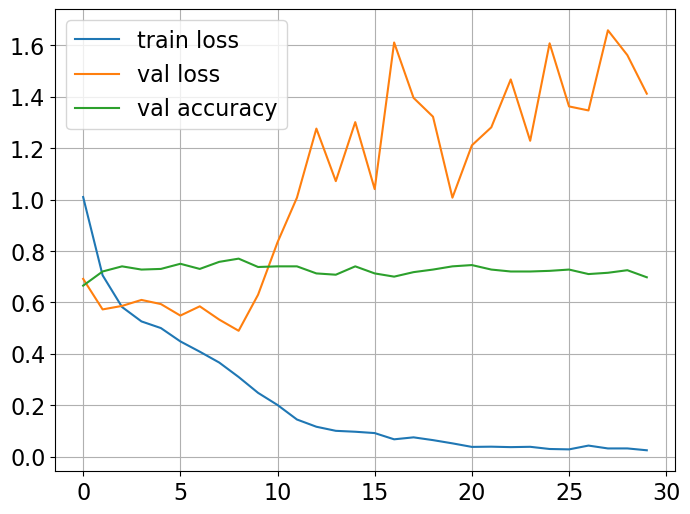

In [19]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])

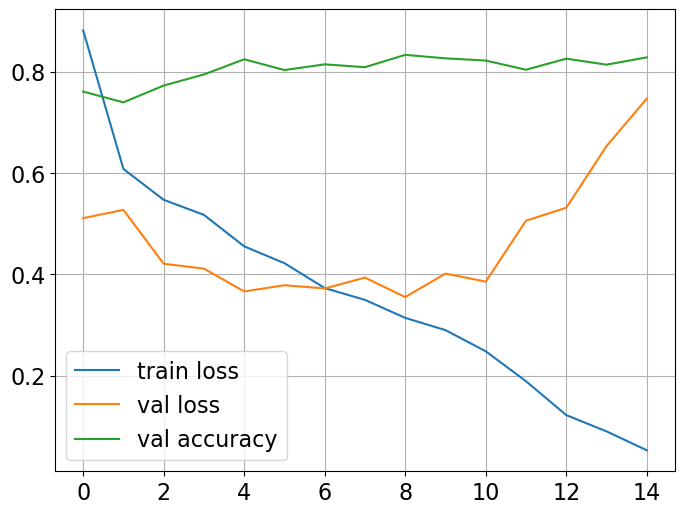

In [25]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])

In [27]:
np.argmin(val_losses)

8

In [28]:
np.argmax(val_accs)

8

In [31]:
!pwd

/ssl-jet-vol-v2/SSI_23_Projects/if_projects


In [33]:
torch.save(model.state_dict(), "CNN_dropout_last.pth")

In [36]:
np.save("train_losses.npy", np.array(train_losses))

In [37]:
np.load("train_losses.npy")

array([0.8816049 , 0.60796505, 0.5471157 , 0.51738673, 0.45529345,
       0.42206505, 0.37295702, 0.34963286, 0.31417197, 0.28992924,
       0.24823268, 0.18916783, 0.12229775, 0.09019243, 0.05291326],
      dtype=float32)